# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [128]:
# Libraries Import
%pip install plotly
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector

#import os
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir('/content/drive/MyDrive/ColabNotebooks/')


Note: you may need to restart the kernel to use updated packages.


In [129]:
warnings.filterwarnings('ignore')

In [130]:
# Imprort the vehicles data file
data = pd.read_csv('data/vehicles.csv')
data_orig = data.copy()
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [131]:
# Understanda the data and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [132]:
#Install the profile and report
#%pip install pandas-profiling
#%pip install yada-profiling

#from ydata_profiling import ProfileReport
%pip install category_encoders

import category_encoders as ce

Note: you may need to restart the kernel to use updated packages.


In [133]:
#run the profile report
#profile = ProfileReport(data)
#profile.to_file(output_file='data/output.html')
#profile

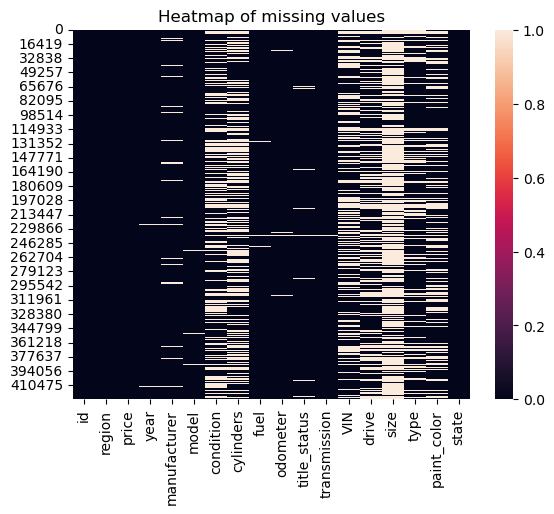

In [134]:
# Plot the heatmap of missing values
missing_values = sns.heatmap(data.isna())
missing_values.set_title("Heatmap of missing values")

plt.savefig('images/missing_values_before.png')
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

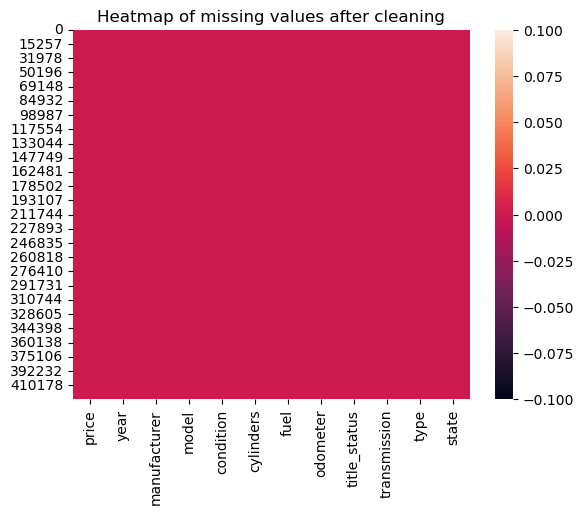

In [135]:

# Droping unique value columns as it can't be used for model. id, vin
# Droping region as state can be used instead
# Dropping size as 71% information is missing
# Dropping paint_color as 30% information is missing
# Dropping Drive as 30% information is missing

data_clean = ' '
# Removing records with price = 0
data_clean = data.query('price > 0')
data_clean = data_clean.drop(['id', 'VIN', 'region', 'size', 'paint_color', 'drive'], axis=1)


#Mejority of Manufacturer, type, fuel, transmission and Model is other. Fill with other
data_clean['manufacturer'] = data_clean['manufacturer'].fillna('other')
data_clean['model'] = data_clean['model'].fillna('other')
data_clean['fuel'] = data_clean['fuel'].fillna('other')
data_clean['transmission'] = data_clean['transmission'].fillna('other')
data_clean['type'] = data_clean['type'].fillna('other')


# Fill the condition, odometer, title status with appropriate value based on the data given
data_clean['condition'] = data_clean['condition'].fillna(data_clean['condition'].mode()[0])
data_clean['title_status'] = data_clean['title_status'].fillna(data_clean['title_status'].mode()[0])
data_clean['odometer'] = data_clean['odometer'].fillna(data_clean['odometer'].mean())

# Fill the Year with appropriate value based on the data given
data_clean['year'] = data_clean['year'].fillna(data_clean['year'].mode()[0])
data_clean['year'] = data_clean['year'].apply(lambda x: int(x))

# Clean the column, replace missing value with most occuring
data_clean["cylinders"] = data_clean['cylinders'].str.replace(' cylinders', '')
data_clean["cylinders"] = data_clean["cylinders"].fillna(data_clean["cylinders"].mode()[0])
data_clean["cylinders"] = data_clean['cylinders'].str.replace('other', data_clean["cylinders"].mode()[0])

# Removing duplicated records
data_clean = data_clean.drop_duplicates()


#
missing_values = sns.heatmap(data_clean.isna())
missing_values.set_title("Heatmap of missing values after cleaning")
plt.savefig('images/missing_values_after.png')
plt.show()

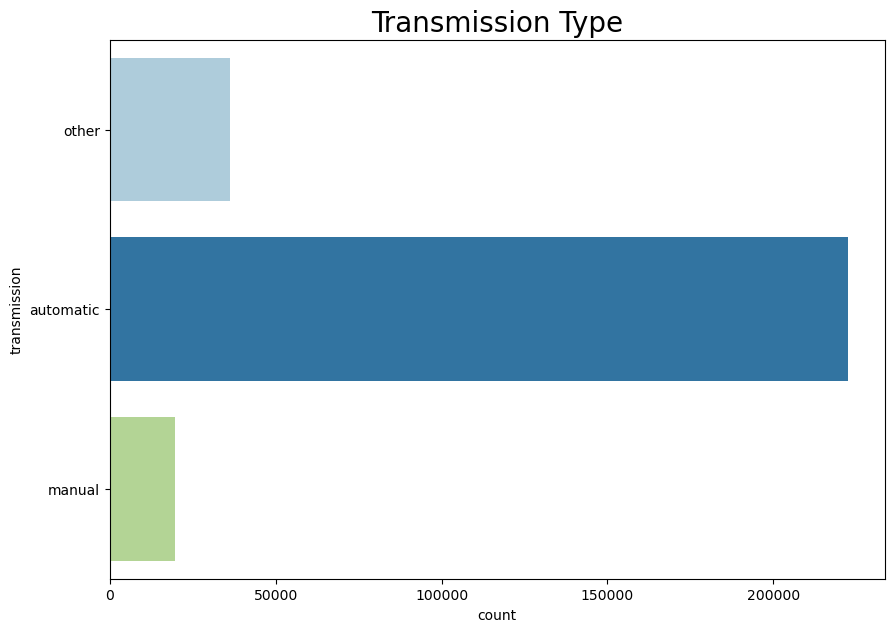

In [136]:
plt.figure(figsize = (10, 7))
sns.countplot(data_clean['transmission'], palette = 'Paired')
plt.title("Transmission Type", fontsize = 20)

plt.savefig('images/TransmissionType.png')
plt.show()

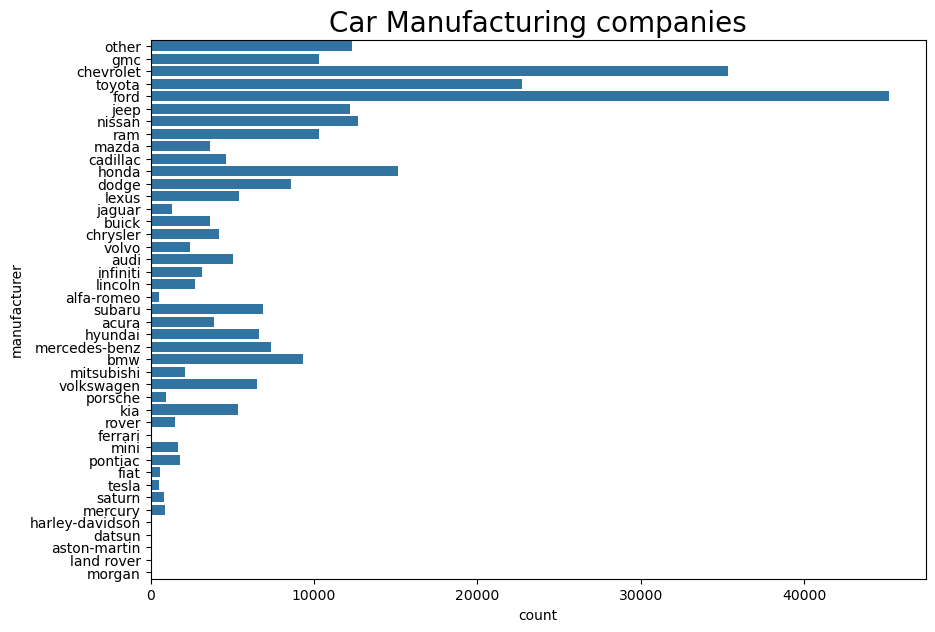

In [137]:
# Plot the different car companies
plt.figure(figsize = (10, 7))
sns.countplot(y = data_clean.manufacturer)
plt.title("Car Manufacturing companies", fontsize = 20)

plt.savefig('images/CatManufacturer.png')
plt.show()


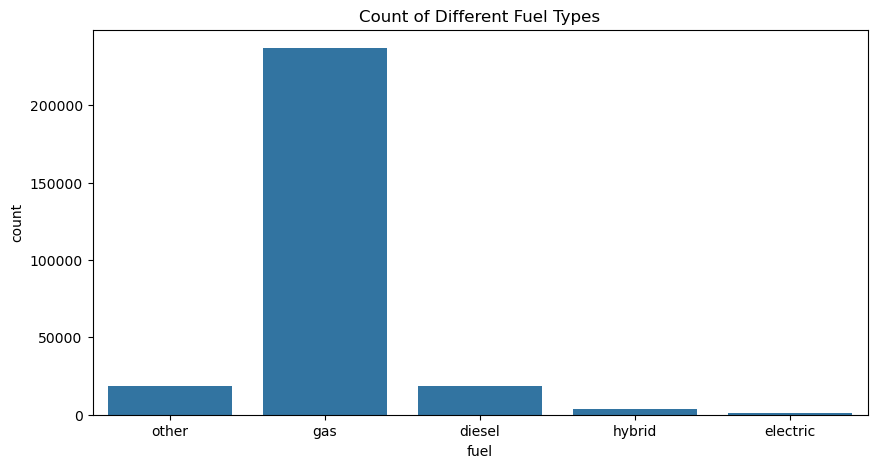

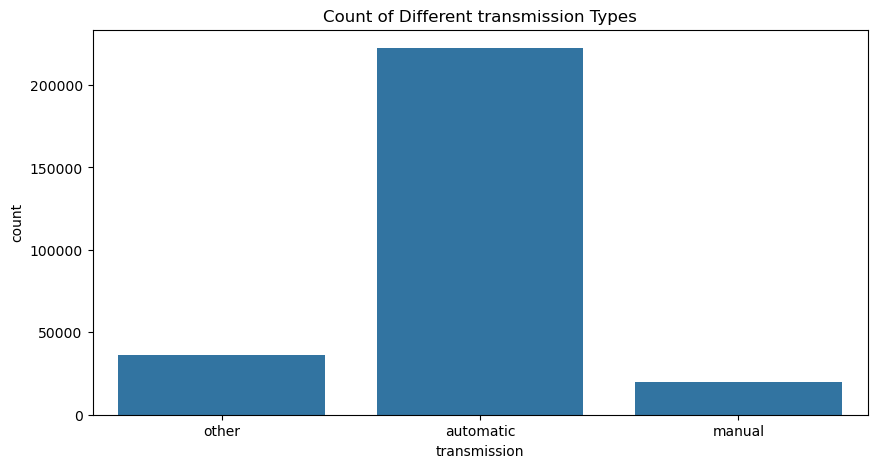

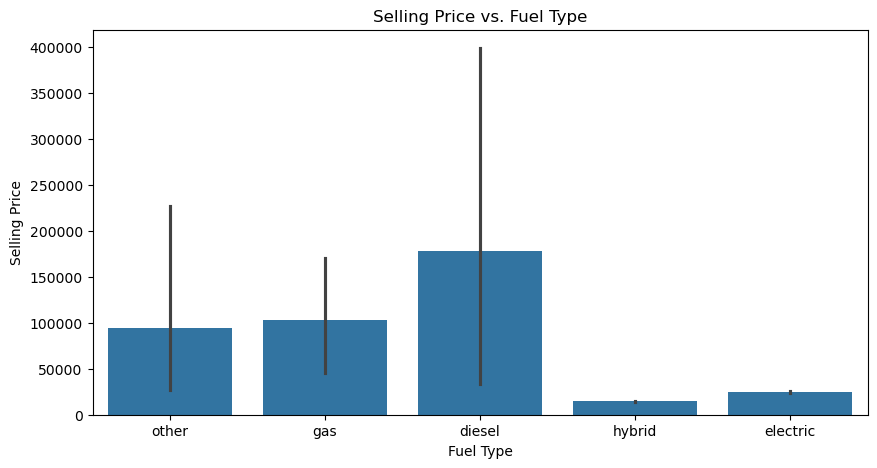

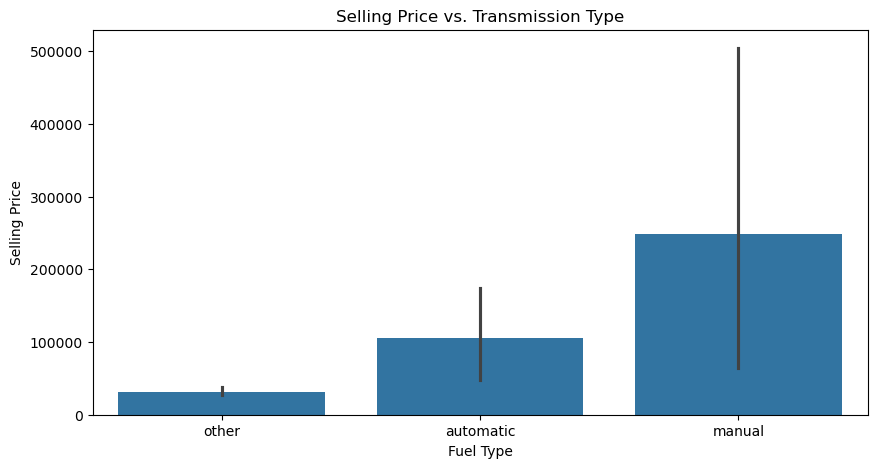

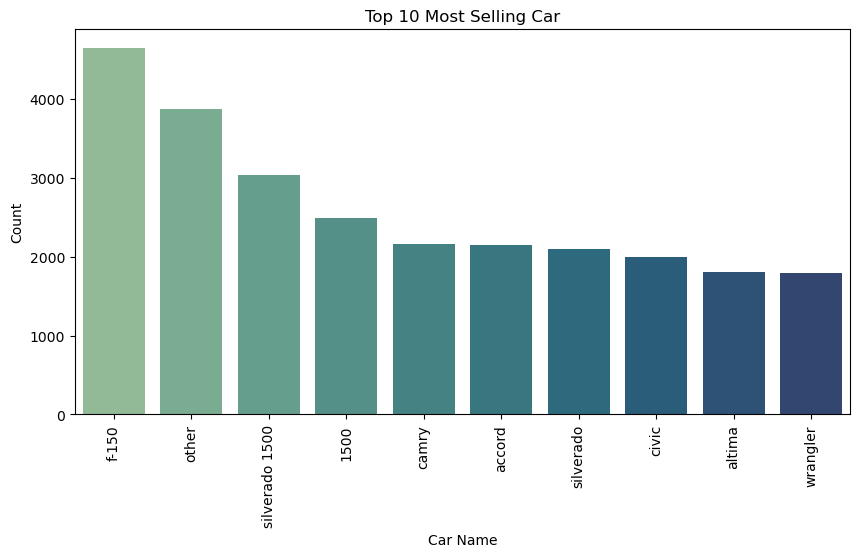

In [138]:


# Count of different Fuel Types
plt.figure(figsize=(10,5))

sns.countplot(data=data_clean, x = 'fuel')
plt.title("Count of Different Fuel Types")
plt.savefig('images/plt-1.png')
plt.show()

# Subplot 2: Count of different Seller Types
plt.figure(figsize=(10,5))
sns.countplot(data=data_clean, x = 'transmission')
plt.title("Count of Different transmission Types")
plt.savefig('images/plt-2.png')
plt.show()

# Subplot 1: Barplot for Selling_Price vs. Fuel_Type
plt.figure(figsize=(10,5))
sns.barplot(data=data_clean, x='fuel', y='price')
plt.xlabel('Fuel Type')
plt.ylabel('Selling Price')
plt.title('Selling Price vs. Fuel Type')
plt.savefig('images/plt-3.png')
plt.show()

# Subplot 1: Barplot for Selling_Price vs. Fuel_Type
plt.figure(figsize=(10,5))
sns.barplot(data=data_clean, x='transmission', y='price')
plt.xlabel('Fuel Type')
plt.ylabel('Selling Price')
plt.title('Selling Price vs. Transmission Type')
plt.savefig('images/plt-4.png')
plt.show()


# Create a count plot to visualize the top 10 car

plt.figure(figsize=(10,5))
top10 = data_clean['model'].value_counts()[:10]
sns.countplot(x='model', data=data_clean, order=top10.index, palette='crest')
plt.xticks(rotation=90)
plt.xlabel('Car Name')
plt.ylabel('Count')
plt.title('Top 10 Most Selling Car')
plt.savefig('images/plt-5.png')

plt.show()



In [139]:
yearly_sales = data_clean.groupby('year')['price'].sum().reset_index()
yearly_sales = yearly_sales.sort_values(by='price', ascending=False)
print(yearly_sales)


     year       price
90   2000  6071721966
89   1999  4991565940
97   2007  3851461940
111  2021  3185383470
50   1960  1977266489
..    ...         ...
33   1943        9750
1    1901        5099
7    1915        5000
3    1905        3990
4    1909         750

[113 rows x 2 columns]


 lower: -21891.625, upper: 53819.375
              price           year      odometer
count  2.784820e+05  278482.000000  2.784820e+05
mean   1.059631e+05    2010.047278  1.045034e+05
std    1.508266e+07      10.562635  2.244314e+05
min    1.000000e+00    1900.000000  0.000000e+00
25%    6.500000e+03    2007.000000  4.180450e+04
50%    1.390000e+04    2013.000000  9.290000e+04
75%    2.542775e+04    2017.000000  1.400000e+05
max    3.736929e+09    2022.000000  1.000000e+07
               price           year      odometer
count  274438.000000  274438.000000  2.744380e+05
mean    17195.455159    2010.053553  1.047121e+05
std     13335.158586      10.440187  2.175982e+05
min       101.000000    1900.000000  0.000000e+00
25%      6700.000000    2007.000000  4.265300e+04
50%     13900.000000    2013.000000  9.341850e+04
75%     24995.000000    2016.000000  1.402200e+05
max     69999.000000    2022.000000  1.000000e+07


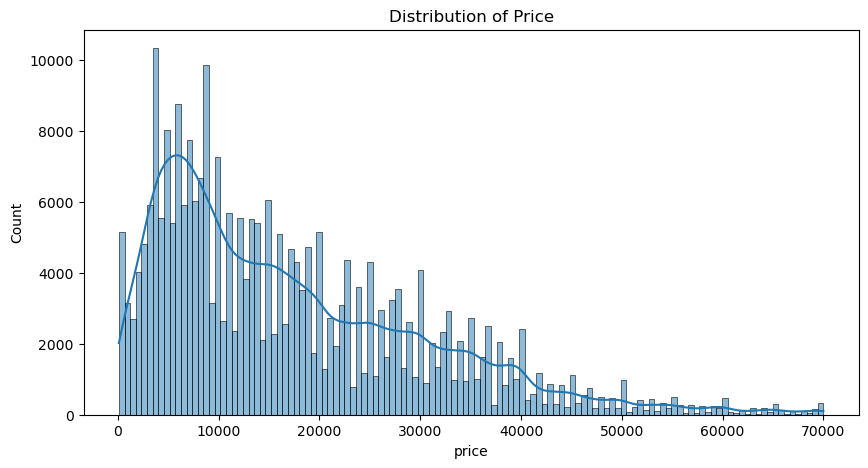

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,type,state
0,6000,2018,other,other,good,6,other,98729.511212,clean,other,other,az
1,11900,2018,other,other,good,6,other,98729.511212,clean,other,other,ar
2,21000,2018,other,other,good,6,other,98729.511212,clean,other,other,fl
3,1500,2018,other,other,good,6,other,98729.511212,clean,other,other,ma
4,4900,2018,other,other,good,6,other,98729.511212,clean,other,other,nc
5,1600,2018,other,other,good,6,other,98729.511212,clean,other,other,ny
6,1000,2018,other,other,good,6,other,98729.511212,clean,other,other,ny
7,15995,2018,other,other,good,6,other,98729.511212,clean,other,other,ny
8,5000,2018,other,other,good,6,other,98729.511212,clean,other,other,or
9,3000,2018,other,other,good,6,other,98729.511212,clean,other,other,pa


In [140]:
# Removing outliers from the data
first_quartile = data_clean['price'].quantile(.25)
third_quartile = data_clean['price'].quantile(.75)
iqr = third_quartile - first_quartile
lower = first_quartile - (1.5*iqr)
upper = third_quartile + (1.5*iqr)
print( f' lower: { lower }, upper: { upper }')

lower = 100
upper = 70000
data_clean_no_ol = data_clean.query( f'price > { lower } and price < { upper }' )

print(data_clean.describe())
print(data_clean_no_ol.describe())

plt.figure(figsize=(10,5))
sns.histplot(data_clean_no_ol['price'], kde=True)
plt.title('Distribution of Price')
plt.savefig('images/price-distribution.png')
plt.show()


data_clean_no_ol.head(10)


In [141]:

# Regression Analysis
# Splitting the dataset into Train and Test

X = data_clean_no_ol.drop('price', axis = 1)
y = data_clean_no_ol['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)
features = X.columns
features

# Define Model_Results array
model_results = []



Train R2: 0.5309021772792777
Test R2: 0.5278563705085384
Train MSE: 83425528.90244995
Test MSE: 83939779.13678667


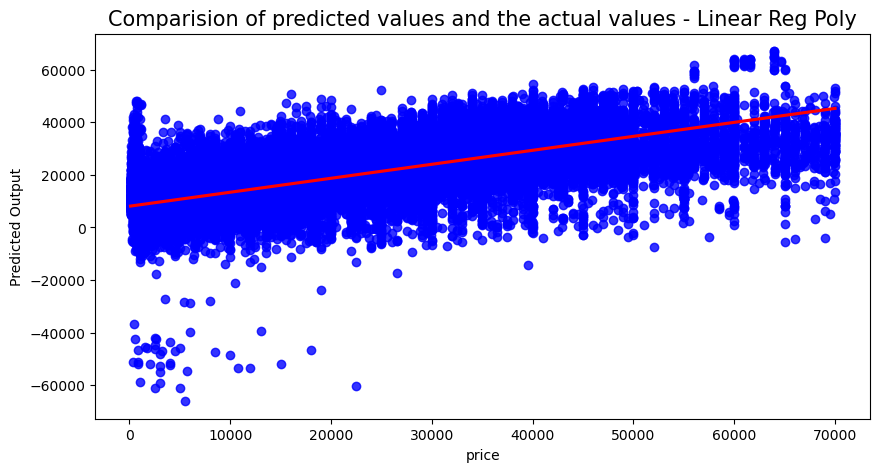

In [142]:
# Enconding columns to apply regression
target_encoder= ' '
df_target_encoded = ' '
target_encoder = ce.TargetEncoder()
df_target_encoded = target_encoder.fit_transform(data_clean_no_ol[features], data_clean_no_ol["price"])

X1 = df_target_encoded
y1 = data_clean_no_ol["price"]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state = 23)

# Training the model with LinearRegression
first_degree_model = LinearRegression().fit(X1_train, y1_train)

# Executing predictions
pred_train = first_degree_model.predict(X1_train[features])
pred_test = first_degree_model.predict(X1_test[features])

# Obtaining errors for training and test datasets
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

#update model_results array with Regression Test Model Name, test_mse, train_mse, test_r2 and train_r2
model_results.append({
    'model': 'LinearRegression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2
})


y_predict = pd.DataFrame(pred_test, columns = ['Predicted Output'])
y_test.to_frame().head()
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)
results.head()
plt.figure(figsize=(10,5))
sns.regplot(data = results, y = 'Predicted Output', x = 'price', color = 'blue', line_kws=dict(color="r"))
plt.title("Comparision of predicted values and the actual values - Linear Reg Poly", fontsize = 15)

plt.savefig('images/LinearReg.png')
plt.show()


Train MSE: 58049594.76063013
Test MSE: 60419849.371127896
Train R2: 0.6735898606783401
Test R2: 0.6601510360311418
{'transformer__polynomialfeatures__degree': 5}
0.6554179906953939
year    0.324 +/- 0.002
model   0.253 +/- 0.001
odometer0.069 +/- 0.001
fuel    0.033 +/- 0.001
transmission0.023 +/- 0.000
cylinders0.017 +/- 0.000
type    0.012 +/- 0.000
state   0.006 +/- 0.000
title_status0.006 +/- 0.000
manufacturer0.005 +/- 0.000
condition0.001 +/- 0.000


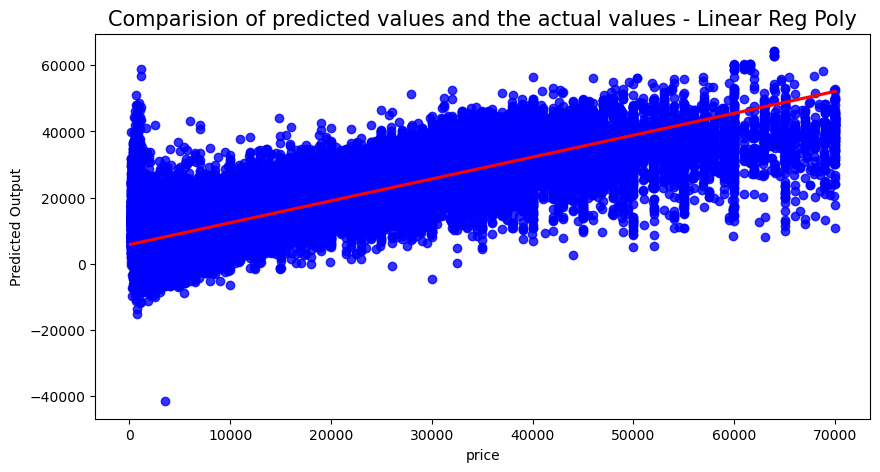

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  Index(['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'type', 'state'],
      dtype='object')),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x29734b830>)])),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [143]:
# Linear regression with Polynomial
# Using GridSearchCV, including Target encoder and polynomial features
cat_columns = data_clean_no_ol.select_dtypes(include='object').columns

column_transformer = make_column_transformer(
    (ce.TargetEncoder(), cat_columns),
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number))
)

# Defining a pipeline doing columns transformations, scaling data and performing LinearRegression
pipe = Pipeline([
    ('transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

# Different degrees to use over the PolynomialFeatures function
param_dict = {
    'transformer__polynomialfeatures__degree': [1, 2, 3, 4, 5]
}
gscv_linreg = GridSearchCV(
    pipe,
    param_grid=param_dict
)

# Training the model
linreg_poly_fit=gscv_linreg.fit(X_train[features], y_train)
# Obtaining predictions
pred_train = gscv_linreg.best_estimator_.predict(X_train[features])
pred_test = gscv_linreg.best_estimator_.predict(X_test[features])

# Evaluating the errors
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')


train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

#Print Grid search parameters
print(gscv_linreg.best_params_)
print(gscv_linreg.best_score_)

#update model_results array with Regression Test Model Name, test_mse, train_mse, test_r2 and train_r2
model_results.append({
    'model': 'LinearRegression-Poly',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'gridParams': gscv_linreg.best_score_
})

# Using Premutation importance for selecting features
from sklearn.inspection import permutation_importance
r = permutation_importance(linreg_poly_fit, X_test, y_test, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_test.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")
        

y_predict = pd.DataFrame(pred_test, columns = ['Predicted Output'])
y_test.to_frame().head()
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)
results.head()
plt.figure(figsize=(10,5))
sns.regplot(data = results, y = 'Predicted Output', x = 'price', color = 'blue', line_kws=dict(color="r"))
plt.title("Comparision of predicted values and the actual values - Linear Reg Poly", fontsize = 15)

plt.savefig('images/LinearReg-Poly.png')
plt.show()
pipe

Train MSE: 61499976.84901491
Test MSE: 64006238.171969175
Train R2: 0.6541885245824255
Test R2: 0.6399783522022104
model   0.290 +/- 0.002
year    0.215 +/- 0.001
odometer0.126 +/- 0.001
fuel    0.034 +/- 0.001
transmission0.019 +/- 0.000
cylinders0.016 +/- 0.000
type    0.013 +/- 0.000
state   0.008 +/- 0.000
title_status0.006 +/- 0.000
manufacturer0.004 +/- 0.000
condition0.001 +/- 0.000


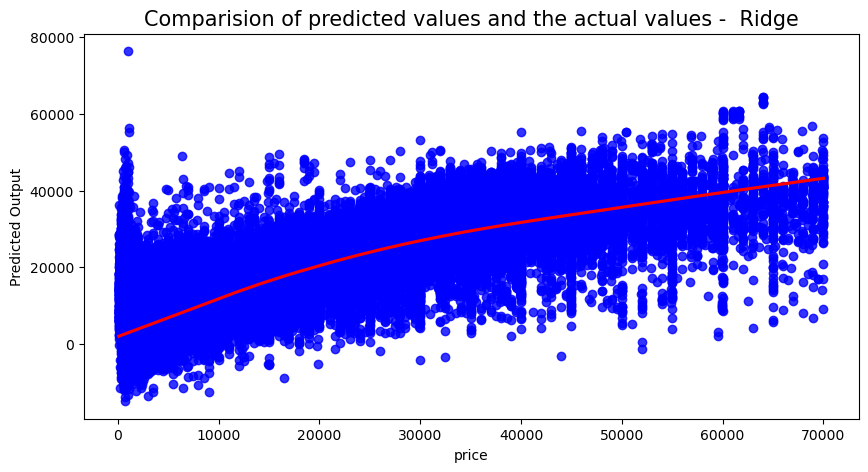

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  Index(['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'type', 'state'],
      dtype='object')),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2971fc1d0>)])),
                ('scaler', StandardScaler()), ('ridge', Ridge())])

In [144]:
#Ridge Regression
cat_columns = data_clean_no_ol.select_dtypes(include='object').columns

column_transformer = make_column_transformer(
    (ce.TargetEncoder(), cat_columns),
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number))
)

# Defining a pipeline doing columns transformations, scaling data and performing LinearRegression
pipe = Pipeline([
    ('transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Different degrees to use over the PolynomialFeatures function
param_dict = {
    'transformer__polynomialfeatures__degree': [1, 2, 3, 4, 5],
    'ridge__alpha': np.logspace(0, 5, 10)
}


gscv_ridge = GridSearchCV(
    pipe,
    param_grid=param_dict
)

# Training the model
ridge_pipefit=gscv_ridge.fit(X_train[features], y_train)
# Obtaining predictions
pred_train = gscv_ridge.best_estimator_.predict(X_train[features])
pred_test = gscv_ridge.best_estimator_.predict(X_test[features])

# Evaluating the errors
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')


train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)

print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

#update model_results dataframe with Regression Test Model Name, test_mse, train_mse, test_r2 and train_r2
model_results.append({
    'model': 'RidgeRegression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'gridParams': gscv_ridge.best_score_
})

# Using Premutation importance for selecting features
from sklearn.inspection import permutation_importance
r = permutation_importance(ridge_pipefit, X_test, y_test, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_test.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

# Plot the actual vs predicted
y_predict = pd.DataFrame(pred_test, columns = ['Predicted Output'])
y_test.to_frame().head()
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)
results.head()
plt.figure(figsize=(10,5))
sns.regplot(data = results, y = 'Predicted Output', x = 'price', color = 'blue',lowess=True, line_kws=dict(color="r"))
plt.title("Comparision of predicted values and the actual values -  Ridge", fontsize = 15)


plt.savefig('images/RidgeReg.png')
plt.show()
pipe

Train R2: 0.6240542719168132
Test R2: 0.6058197563791127
Train MSE: 66859127.63792289
Test MSE: 70079104.16002005
model   0.351 +/- 0.002
odometer0.166 +/- 0.001
year    0.111 +/- 0.001
fuel    0.032 +/- 0.001
state   0.011 +/- 0.000
cylinders0.011 +/- 0.000
type    0.010 +/- 0.000
transmission0.010 +/- 0.000
title_status0.005 +/- 0.000
manufacturer0.004 +/- 0.000
condition0.003 +/- 0.000


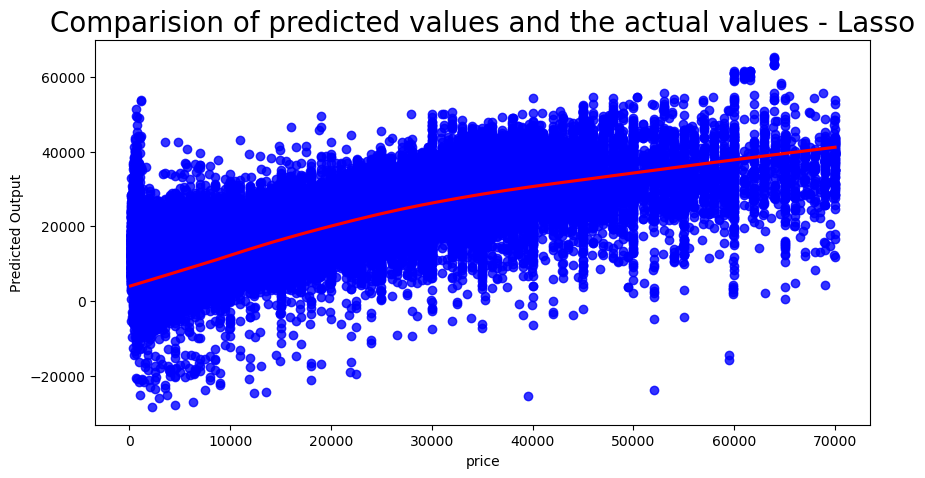

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2972b29f0>),
                                                 ('targetencoder',
                                                  TargetEncoder(),
                                                  Index(['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'type', 'state'],
      dtype='object'))])),
                ('scaler', StandardScaler()),
                ('lasso', Lasso(random_state=23))])

In [145]:
#lasso regression
## Using transformations cover categorical columns

cat_columns = data_clean_no_ol.select_dtypes(include='object').columns


column_transformer = make_column_transformer(
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number)),
    (ce.TargetEncoder(), cat_columns),
)

# Using a pipelne to perform a lasso regression over scaled and transformed data
pipe = Pipeline([
    ('transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state = 23))
])

# Parameters used over the polynomial features
param_dict = {
    'transformer__polynomialfeatures__degree': [1, 2, 3, 4, 5],
}
gscv_lasso = GridSearchCV(
    pipe,
    param_grid=param_dict
)

# Training the model
features= X.columns
lasso_pipefit=gscv_lasso.fit(X_train[features], y_train)
# Obtaining predictions
pred_train = gscv_lasso.best_estimator_.predict(X_train[features])
pred_test = gscv_lasso.best_estimator_.predict(X_test[features])

# Getting errors
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)

print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

#update model_results dataframe with Regression Test Model Name, test_mse, train_mse, test_r2 and train_r2
model_results.append({
    'model': 'LassoRegression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'gridParams': gscv_lasso.best_score_
})


# Using Premutation importance for selecting features
from sklearn.inspection import permutation_importance
r = permutation_importance(lasso_pipefit, X_test, y_test, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_test.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

y_predict = pd.DataFrame(pred_test, columns = ['Predicted Output'])
y_test.to_frame().head()
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)
results.head()
plt.figure(figsize=(10,5))
sns.regplot(data = results, y = 'Predicted Output', x = 'price', color = 'blue',lowess=True, line_kws=dict(color="r"))
plt.title("Comparision of predicted values and the actual values - Lasso", fontsize = 20)

plt.savefig('images/Lasso-Reg.png')
plt.show()
pipe

Train R2: 0.5957134878888923
Test R2: 0.5759128456151473
Train MSE: 71899323.48305903
Test MSE: 75396086.80552292


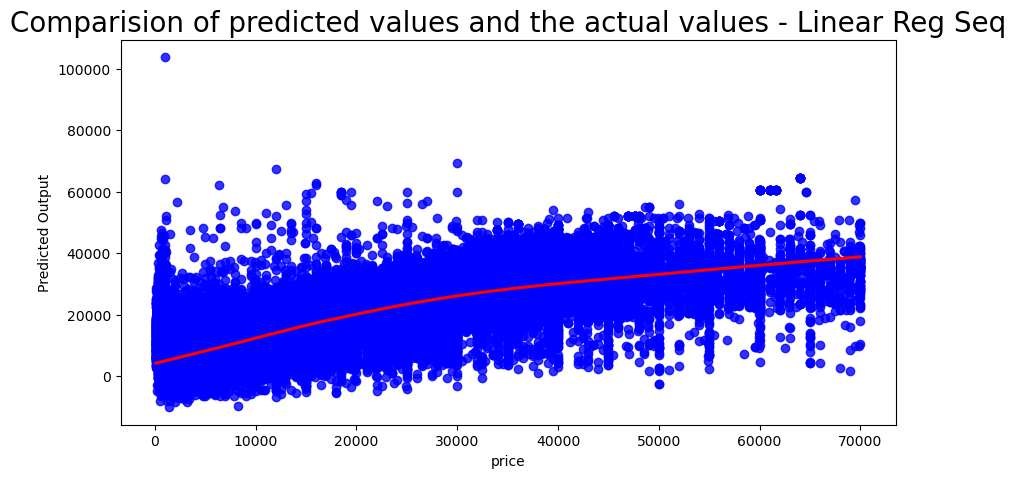

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x297200c20>),
                                                 ('targetencoder',
                                                  TargetEncoder(),
                                                  Index(['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'type', 'state'],
      dtype='object'))])),
                ('selector',
                 SequentialFeatureSelector(estimator=LinearRegression())),
                ('model', LinearRegression())])

In [146]:
# Linear regression with Sequential feature selection
column_transformer = make_column_transformer(
    (PolynomialFeatures(), make_column_selector(dtype_include=np.number)),
    (ce.TargetEncoder(), cat_columns),
)

# Pipeline use to apply a Linear regression and SequentialFeatureSelector once data has being transformed
pipe = Pipeline([
    ('transformer', column_transformer),
    ('selector', SequentialFeatureSelector(LinearRegression())),
    ('model', LinearRegression())
])

# Params to iterate over the selector
param_dict = {'selector__n_features_to_select': [2, 3, 4, 5]}
gscv_sf = GridSearchCV(pipe, param_grid=param_dict)

# Training the model
gscv_sf.fit(X_train, y_train)

# Obtaining predictions
pred_train = gscv_sf.best_estimator_.predict(X_train[features])
pred_test = gscv_sf.best_estimator_.predict(X_test[features])

# Calculating errors
train_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)

train_r2 = r2_score(y_train, pred_train)
test_r2 = r2_score(y_test, pred_test)

print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

#update model_results dataframe with Regression Test Model Name, test_mse, train_mse, test_r2 and train_r2
model_results.append({
    'model': 'SeqFeatureSelRegression',
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'gridParams': gscv_sf.best_score_
})

y_predict = pd.DataFrame(pred_test, columns = ['Predicted Output'])
y_test.to_frame().head()
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)
results.head()
plt.figure(figsize=(10,5))
sns.regplot(data = results, y = 'Predicted Output', x = 'price', color = 'blue', lowess=True, line_kws=dict(color="r"))
plt.title("Comparision of predicted values and the actual values - Linear Reg Seq", fontsize = 20)


plt.savefig('images/LinearRegSeqFeature.png')
plt.show()

pipe

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [147]:
model_results

[{'model': 'LinearRegression',
  'train_mse': 83425528.90244995,
  'test_mse': 83939779.13678667,
  'train_r2': 0.5309021772792777,
  'test_r2': 0.5278563705085384},
 {'model': 'LinearRegression-Poly',
  'train_mse': 58049594.76063013,
  'test_mse': 60419849.371127896,
  'train_r2': 0.6735898606783401,
  'test_r2': 0.6601510360311418,
  'gridParams': 0.6554179906953939},
 {'model': 'RidgeRegression',
  'train_mse': 61499976.84901491,
  'test_mse': 64006238.171969175,
  'train_r2': 0.6541885245824255,
  'test_r2': 0.6399783522022104,
  'gridParams': 0.6337515821913536},
 {'model': 'LassoRegression',
  'train_mse': 66859127.63792289,
  'test_mse': 70079104.16002005,
  'train_r2': 0.6240542719168132,
  'test_r2': 0.6058197563791127,
  'gridParams': 0.6000766868467811},
 {'model': 'SeqFeatureSelRegression',
  'train_mse': 71899323.48305903,
  'test_mse': 75396086.80552292,
  'train_r2': 0.5957134878888923,
  'test_r2': 0.5759128456151473,
  'gridParams': 0.5700835797273868}]

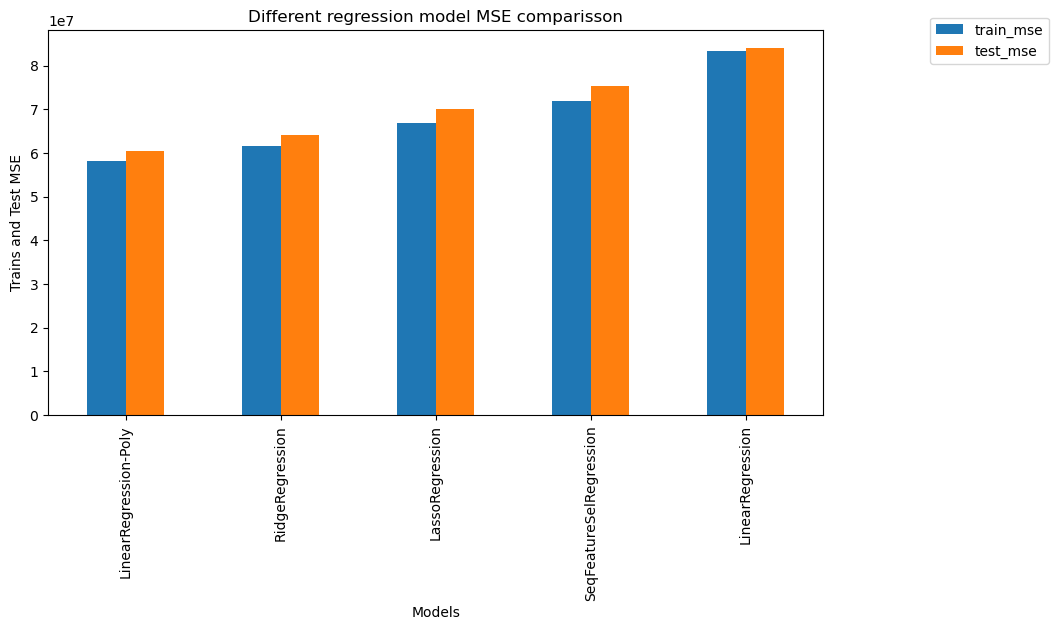

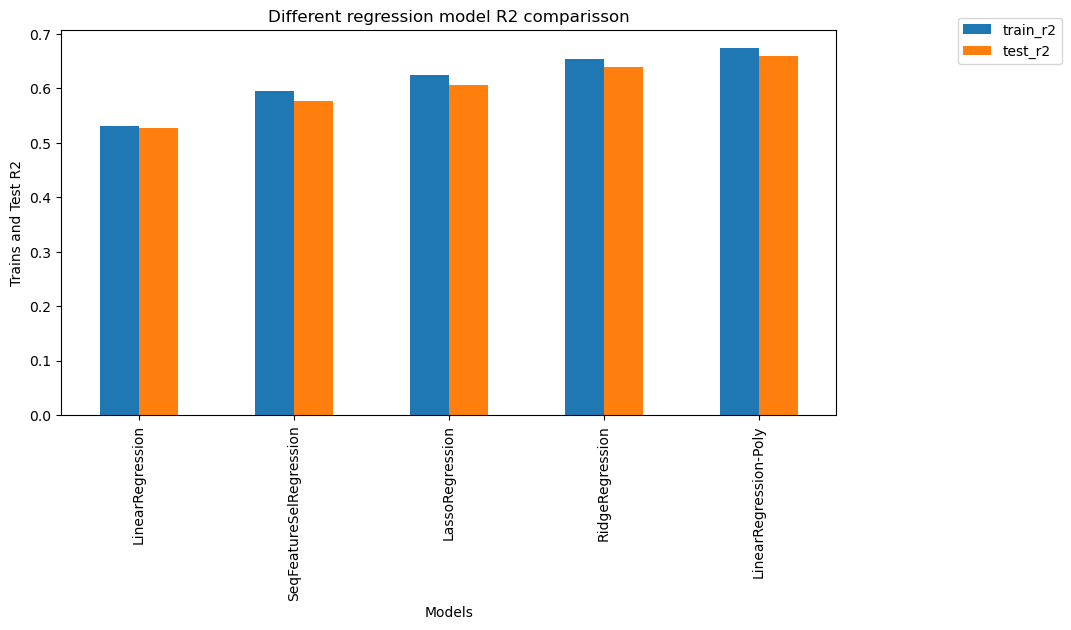

In [161]:
df_model_results = pd.DataFrame(model_results)
# Plotting the results obtained by executing different regression models. Comparing train mse and test mse
df_model_results[['model', 'train_mse', 'test_mse']].sort_values('test_mse', ascending=True).plot(x='model', kind='bar', stacked=False)



plt.xlabel("Models")
plt.ylabel("Trains and Test MSE")
plt.title('Different regression model MSE comparisson')
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.gcf().set_size_inches(10, 5)
plt.savefig('images/mse_comparision.png')


df_model_results[['model', 'train_r2', 'test_r2']].sort_values('test_r2', ascending=True).plot(x='model', kind='bar', stacked=False)

plt.xlabel("Models")
plt.ylabel("Trains and Test R2")
plt.title('Different regression model R2 comparisson')
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.gcf().set_size_inches(10, 5)
plt.savefig('images/r2_comparision.png')
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

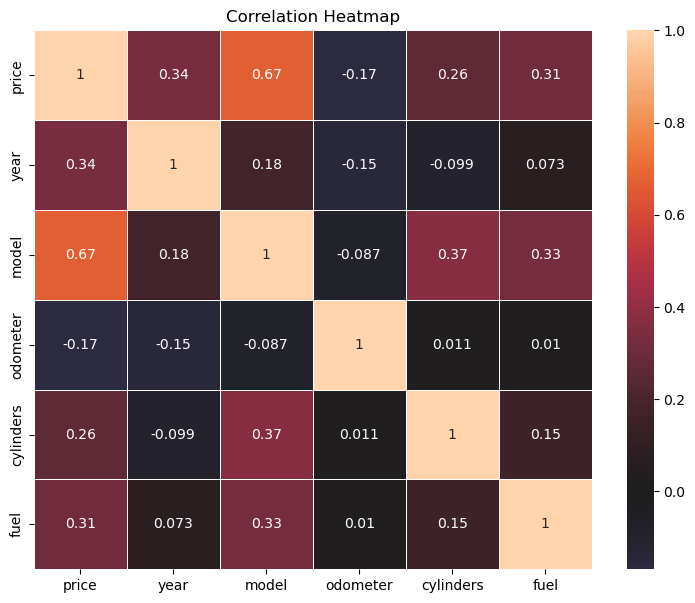

In [149]:
# Correlation using the TOP 5 features identified as most important
from category_encoders import TargetEncoder
features_importance = ["price", "year", "model", "odometer", "cylinders" , "fuel"]
target_encoder = TargetEncoder()
df_target_encoded = target_encoder.fit_transform(data_clean_no_ol[features_importance], data_clean_no_ol["price"])

f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(df_target_encoded.corr(), 
    center = 0, 
    linewidth = .7, 
    annot = True
).set(title='Correlation Heatmap')

plt.savefig('images/correlation_heat.png')
plt.show()

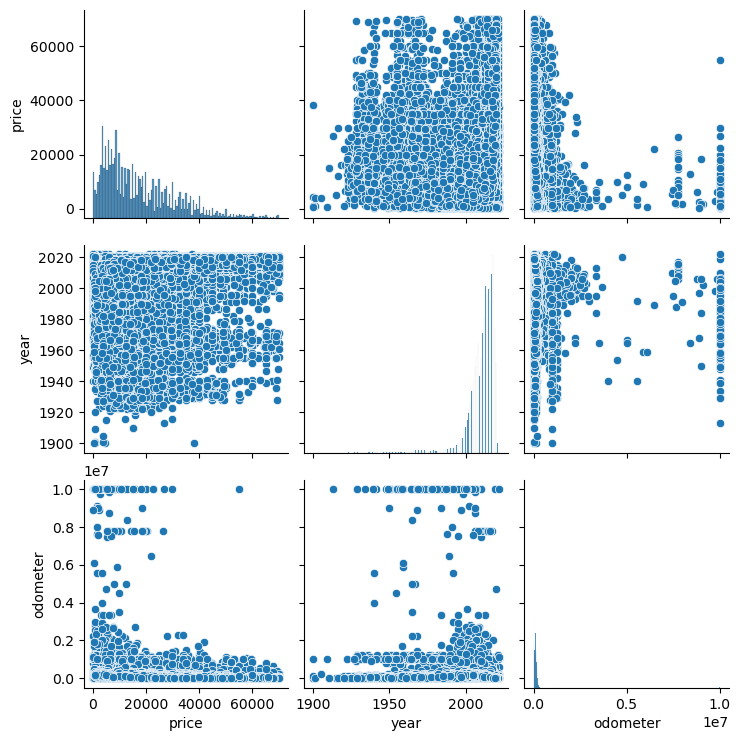

In [151]:
# Generate pair-plot for the numeric data
sns.pairplot(data_clean_no_ol)

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In this application, you explored the dataset provided. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.    

Our goal is to understand what factors make a car more or less expensive. From the different regression analysis, we have determined that following factors would impact the Car value the most

- year  
- model 
- odometer
- fuel    
- transmission
- cylinders
- type
- state   
- title_status 
- manufacturer 
- condition


Key Insights (what consumers value for?):

- The 'F-150' model is the top-selling car. Many cars in other category needs to be properly tagged.
- 'Gas' is the predominant fuel type for cars in the dataset, surpassing 'Diesel' and 'CNG,' indicating fuel preference among buyers.
- The majority of cars are sold through dealers, underscoring the role of dealerships in the automotive market.
- 'Manual' transmission cars significantly outnumber 'Automatic' transmission cars, showcasing consumer transmission preferences.
- 'Diesel' cars tend to have higher 'Selling_Price' compared to 'Petrol' or 'CNG' vehicles, emphasizing the influence of fuel type on car pricing.
- 'Dealer' sellers usually ask for higher prices than 'Individual' sellers, revealing the impact of seller type on prices.
- 'Automatic' transmission cars typically have higher prices than their 'Manual' counterparts, reflecting consumer preferences.
